<center>

<h1>$\textbf{Stochastic Multi Armed Bandits}$</h1>


$\textit{Author : Antonios Kastellakis}$<br>
<br>



The Stochastic Multi-Armed Bandit (MAB) problem is a classical problem in decision theory and reinforcement learning. The enviroment consists of a set of k arms, that can be played. Each arm has reward that comes from an unknown probability distribution and the objective is to identify the arm with the highest reward by repeatedly playing the arms and observing the outcomes within a fixed time horizon T.

At each time step $t$, we select an arm i to play and receive a reward $r(t,i)$ sampled from the probability distribution of the selected arm. The goal is to maximize the total expected reward over the finite time horizon $T$.

The key difficulty in the MAB problem is to balance exploration and exploitation. On the one hand, it is necessary to explore the different machines to learn their respective probability distributions. On the other hand, it is important to exploit the current knowledge to select the machine that is most likely to give the highest reward. The challenge lies in deciding
how much to explore and how much to exploit at each time step in order to achieve the maximum expected reward.

In [14]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [15]:
# Creating our environment
# We have k stochastic arms
k = 10

# Horizon of the algorithms
T = 1000

# Each arm i has a reward that is uniformly distributed in [a_i, b_i].
# a_i, b_i should be chosen randomly in [0,1] and must be different for each arm i.

# Generating random distribution parameters for each arm
arms_dist = np.sort(np.round(np.random.uniform(low=0, high=1, size=(k, 2)), 2))

# Initialize sets to keep track of used values for a_i and b_i
used_a_vals = set()
used_b_vals = set()

# Loop through each arm and ensure unique distribution parameters for each arm
for i in range(k):
    if i == 0:
        # For the first arm, directly use the randomly generated distribution parameters
        used_a_vals.add(arms_dist[0, 0])
        used_b_vals.add(arms_dist[0, 1])
    else:
        # Assess the validity of the new distribution parameters for other arms
        new_params = np.sort(np.round(np.random.uniform(low=0, high=1, size=(1, 2)), 2))
        used = True

        # Ensure unique a_i value for the new arm
        while used:
            if new_params[0, 0] in used_a_vals:
                new_params[0, 0] = np.round(np.random.uniform(low=0, high=1), 2)
            if new_params[0, 0] not in used_a_vals:
                used_a_vals.add(new_params[0, 0])
                used = False

        used = True

        # Ensure unique b_i value for the new arm
        while used:
            if new_params[0, 1] in used_b_vals:
                new_params[0, 1] = np.round(np.random.uniform(low=0, high=1), 2)
            if new_params[0, 1] not in used_b_vals:
                used_b_vals.add(new_params[0, 1])
                used = False

        # Concatenate the new distribution parameters to the existing arms_dist array
        arms_dist = np.concatenate((arms_dist, new_params), axis=0)

In [16]:
# Run this if you don't have latex installed in Collab
#! sudo apt-get install texlive-latex-recommended

<h3>$\boldsymbol{\epsilon}\textbf{-Greedy algorithm}$</h3>

Unlike the Explore-then-Exploit algorithm, this algorithm does not rely solely on exploration during its initial rounds. Specifically, at each round $t$, we select an arm to play at random from the available options with a probability of epsilon $\epsilon_t$, and choosing the arm with the highest expected reward with a probability of $1-\epsilon_t$. To attain sub-linear regret, indicating that we are able to "learn", we adjust the value of $\epsilon_t$ to wane with each round $t$.

During the initial rounds, we set the value of $\epsilon_t$ to be high, so there is more exploration and less exploitation. This can be advantageous since there is considerable uncertainty in the reward distributions of the arms. Conversely, as the number of rounds increases and the value of $\epsilon_t$ shrinks, there is more exploitation and less exploration, which is beneficial as we have already acquired a thorough understanding of the reward distributions and we desire to concentrate on exploiting the arm that offers the highest expected reward.

In [17]:
def epsilon_greedy(k, T, arms_dist):
    """
    Implementation of the epsilon-greedy algorithm for multi-armed bandits.

    Parameters:
        k (int): Number of arms (actions) in the bandit problem.
        T (int): Total number of rounds (time steps) to run the algorithm.
        arms_dist (numpy.ndarray): A 2D array of shape (k, 2) representing the distribution
            of rewards for each arm. Each row contains two values [low, high], specifying
            the lower and upper bounds of the reward distribution for the corresponding arm.

    Returns:
        numpy.ndarray: A 1D array of shape (T+1,) containing the cumulative regret at each time step t.
    """

    # Means of each arm
    true_means = np.mean(arms_dist, axis=1)

    # Best arm (index of the arm with the highest mean)
    best_arm = np.argmax(true_means)

    # Estimated mean reward of each arm through the data
    sample_means = np.zeros((k,))

    # Num of arm pulls
    pulls = np.zeros((k,))

    # Cumulative reward of each arm for round t
    r_t = np.zeros((k,))

    # Reward for round t
    inst_score = np.zeros((T+1,))

    # Cumulative reward of best arm for round t
    best_score = np.zeros((T+1,))

    # Cumulative reward for round t
    e_greedy_alg_score = np.zeros((T+1,))

    # Regret for round t
    e_greedy_regret =  np.zeros((T+1,))

    for t in range(1, T+1):

        # With probability e_t pick a random arm
        # else with probability 1-e_t pick the best arm
        e_t =  min(1, ( t**(-1/3) * (k * np.log(t))**(1/3) ) )
        p = np.random.uniform(low=0, high=1)

        if e_t > p:
            # Choose a random arm
            arm = np.random.randint(low=0, high=k)
        else:
            # Choose the best arm at round t
            arm = np.argmax(sample_means)

        # Update the number of pulls of the chosen arm
        pulls[arm] += 1

        # Sample reward of chosen arm at round t
        inst_score[t] = np.random.uniform(low=arms_dist[arm, 0], high=arms_dist[arm, 1])

        # Cumulative reward of chosen arm for round t
        r_t[arm] += inst_score[t]

        # Update mean estimate for chosen arm
        sample_means[arm] = r_t[arm] / pulls[arm]

        # Cumulative algorithm reward for round t
        e_greedy_alg_score[t] = e_greedy_alg_score[t-1] + inst_score[t]

        # Cumulative reward of best arm for round t
        best_score[t] = best_score[t-1] + true_means[best_arm]

        # Regret for round t
        e_greedy_regret[t] = (best_score[t] - e_greedy_alg_score[t]) / t

    return np.reshape(e_greedy_regret,(1,T+1))


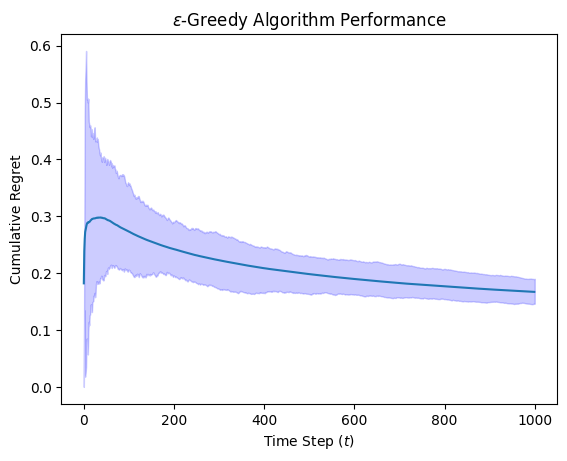

In [18]:
# Number of experiments
num_of_experiments = 1000

# Regret of experiments (stores the cumulative regret for each experiment)
regret_epsilon_greedy = np.zeros((num_of_experiments, T+1))

# Regret for every experiment
for experiment in range(num_of_experiments):
    regret_epsilon_greedy[experiment] = epsilon_greedy(k, T, arms_dist)

# Calculate the expected regret across all experiments (averaging over all trials)
expected_regret_e_greedy = np.mean(regret_epsilon_greedy, axis=0)

# Plot the expected regret over time steps (excluding t=0, as regret is undefined at t=0)
plt.plot(expected_regret_e_greedy[1::])

# Fill the area between the minimum and maximum regret observed at each time step
plt.fill_between(np.arange(len(expected_regret_e_greedy)), np.min(regret_epsilon_greedy, axis=0), np.max(regret_epsilon_greedy, axis=0), color='blue', alpha=0.2)

# Add title and axis labels
plt.title('$\epsilon$-Greedy Algorithm Performance')
plt.xlabel('Time Step ($t$)')
plt.ylabel('Cumulative Regret')

# Show the plot
plt.show()


<h3>$\textbf{ Upper Confidence Bound (UCB) algorithm }$</h3>

The $\epsilon$-Greedy algorithm has various advantages compared to the Explore-then-Exploit algorithm. However, neither one of these algorithms is optimal as during exploration, both explore any arm, even ones that seem bad, with equal probability. This is where the Upper Confidence Bounds (UCB) algorithm comes into play. The algorithm calculates the upper confidence bound for each arm by utilizing a confidence interval based on the number of times the arm has been played and the rewards obtained so far. The arm with the highest upper confidence bound is selected for each round. This strikes a balance between exploration and exploitation by prioritizing arms with a higher potential reward, while also ensuring that all arms are eventually explored.

In [19]:
def UCB(k, T, arms_dist):
    """
    Implementation of the Upper Confidence Bound (UCB) algorithm for multi-armed bandits.

    Parameters:
        k (int): Number of arms (actions) in the bandit problem.
        T (int): Total number of rounds (time steps) to run the algorithm.
        arms_dist (numpy.ndarray): A 2D array of shape (k, 2) representing the distribution
            of rewards for each arm. Each row contains two values [low, high], specifying
            the lower and upper bounds of the reward distribution for the corresponding arm.

    Returns:
        numpy.ndarray: A 1D array of shape (T+1,) containing the cumulative regret at each time step t.
    """

    # Means of each arm
    true_means = np.mean(arms_dist, axis=1)

    # Best arm (index of the arm with the highest mean)
    best_arm = np.argmax(true_means)

    # Estimated mean reward of each arm through the data
    sample_means = np.zeros((k,))

    # Upper confidence bounds for round t
    UCB_t = np.zeros((k,))

    # Num of arm pulls
    pulls = np.zeros((k,))

    # Cumulative reward of each arm for round t
    r_t = np.zeros((k,))

    # Reward for round t
    inst_score = np.zeros((T+1,))

    # Cumulative reward of best arm for round t
    best_score = np.zeros((T+1,))

    # Cumulative reward for round t
    UCB_alg_score = np.zeros((T+1,))

    # Regret for round t
    UCB_regret =  np.zeros((T+1,))

    for t in range(1, T+1):

        if t <= 10:
            # First play each arm at least once
            arm = t - 1
        else:
            # Choose the arm with the best UCB score at round t
            arm = np.argmax(UCB_t)

        # Update the number of pulls of the chosen arm
        pulls[arm] += 1

        # Sample reward of chosen arm at round t
        inst_score[t] = np.random.uniform(low=arms_dist[arm, 0], high=arms_dist[arm, 1])

        # Cumulative reward of chosen arm for round t
        r_t[arm] += inst_score[t]

        # Update mean estimate for chosen arm
        sample_means[arm] = r_t[arm] / pulls[arm]

        # Update UCB score for chosen arm
        UCB_t[arm] = sample_means[arm] + math.sqrt((math.log(T)) / pulls[arm])

        # Cumulative algorithm reward for round t
        UCB_alg_score[t] = UCB_alg_score[t-1] + inst_score[t]

        # Cumulative reward of best arm for round t
        best_score[t] = best_score[t-1] + true_means[best_arm]

        # Regret for round t
        UCB_regret[t] = (best_score[t] - UCB_alg_score[t]) / t

    return UCB_regret

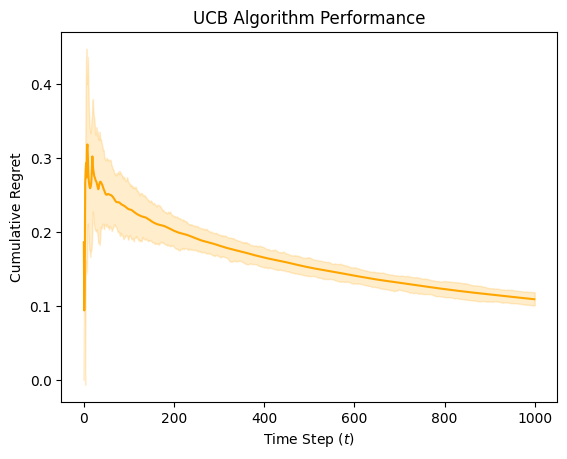

In [20]:
# Regret of experiments (stores the cumulative regret for each experiment)
regret_UCB = np.zeros((num_of_experiments, T+1))

# Regret for every experiment
for experiment in range(num_of_experiments):
    regret_UCB[experiment] = UCB(k, T, arms_dist)

# Calculate the expected regret across all experiments (averaging over all trials)
expected_regret_UCB = np.mean(regret_UCB, axis=0)

# Plot the expected regret over time steps (excluding t=0, as regret is undefined at t=0)
plt.plot(expected_regret_UCB[1::], color='orange')

# Fill the area between the minimum and maximum regret observed at each time step
plt.fill_between(np.arange(len(expected_regret_UCB)), np.min(regret_UCB, axis=0), np.max(regret_UCB, axis=0), color='orange', alpha=0.2)

# Add title and axis labels
plt.title('UCB Algorithm Performance')
plt.xlabel('Time Step ($t$)')
plt.ylabel('Cumulative Regret')

# Show the plot
plt.show()

To see how the algorithms work in practise and compare their learning speed/convergence, we created an environment with 10 arms and a fixed horizon of T=1000 rounds.

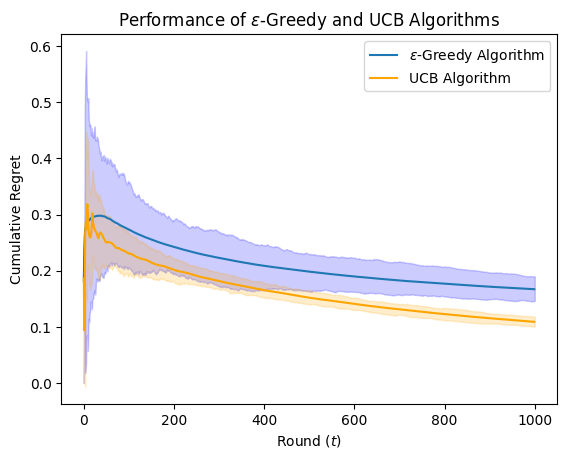

In [21]:
# Plot the performance of both algorithms

# Plot the expected regret over time steps for epsilon-Greedy algorithm
plt.plot(expected_regret_e_greedy[1::], label='$\epsilon$-Greedy Algorithm')

# Fill the area between the minimum and maximum regret observed at each time step for epsilon-Greedy algorithm
plt.fill_between(np.arange(len(expected_regret_e_greedy)), np.min(regret_epsilon_greedy, axis=0), np.max(regret_epsilon_greedy, axis=0), color='blue', alpha=0.2)

# Plot the expected regret over time steps for UCB algorithm
plt.plot(expected_regret_UCB[1::], color='orange', label='UCB Algorithm')

# Fill the area between the minimum and maximum regret observed at each time step for UCB algorithm
plt.fill_between(np.arange(len(expected_regret_UCB)), np.min(regret_UCB, axis=0), np.max(regret_UCB, axis=0), color='orange', alpha=0.2)

# Add title and axis labels
plt.title('Performance of $\epsilon$-Greedy and UCB Algorithms')
plt.xlabel('Round ($t$)')
plt.ylabel('Cumulative Regret')

# Show the legend
plt.legend()

# Show the plot
plt.show()


With an increasing number of rounds, both algorithms exhibit an exponential decrease in expected regret, indicating learning. As anticipated, UCB displays faster convergence/learning compared to $\epsilon$-Greedy. It is worth noting that $\epsilon$-Greedy's expected regret exhibits greater fluctuations due to its random selection of any arm with equal probability, including those with low rewards. In contrast, UCB gives priority to arms that appear promising but haven't been sufficiently explored. With an increasing number of samples, the upper confidence bounds become more precise, enabling the algorithm to make more confident selections.

<h1>$\textbf{Experts and Adversarial Bandits}$</h1>

Moving forward we shall work with a normalized dataset containing actual traffic loads for several servers, where the demands are not stationary. Our goal is to implement algorithms that learn to predict the least loaded server at every time round and compare their performance.

<h3>$\textbf{Multiplicative Weights Algorithm}$</h3>

The first algorithm we will implement is the Multiplicative Weights algorithm (MWA) or Hedge, which is used in online decision-making problems in the context of "adversarial bandit problems". The MWA works by maintaining a collection of weights for each action that reflect our current understanding of the expected reward for each action. At each time step, we select an action by taking into account a probability distribution that is weighted over the possible actions. The weight of each action is adjusted according to the observed reward, using a learning rate parameter. The learning rate determines how quickly we adjust our beliefs about the expected rewards of each action.

We will explore two different settings of the MWA algorithm. The first assumes an "Experts" environment, where we get to learn the load of other servers at every round, not just the one we chose. The second approach considers a "Bandit" environment, where the only available information is from the server we chose at each round. It is obvious that the "Expert" setting will have a faster convergence as it utilizes knowledge of all the servers to update all the weights at each round. While, the "Bandits" setting can only update the weight of the chosen server at each round, and hence, it will learn slower.

In [22]:
def MWA_experts(data, horizon):
    """
    Moving Weighted Average (MWA) algorithm assuming an "experts" environment,
    where you get to learn the load of other servers at every round, not just the one you chose.

    Parameters:
    data (numpy.ndarray): A 2D array containing the normalized traffic loads for k servers over T rounds.
                          Each row represents the load sequence of a server.
    horizon (int): The desired time horizon to consider for the analysis. If horizon is greater than T,
                   the horizon will be set to T, which is the total number of rounds in the dataset.

    Returns:
    numpy.ndarray: An array containing the regret of the MWA algorithm at each round.
    """
    # Get total number of experts (servers) and the horizon of the data
    k, T = np.shape(data)

    if horizon > T:
        print("The requested horizon is bigger than the horizon of the dataset.\n\
        The horizon of the dataset is set as the default.")
    else:
        T = horizon

    # Compute the mean loss of each expert
    mean_loss = np.mean(data[:, :T], axis=1)

    # Determine the best expert
    best_expert = np.argmin(mean_loss)

    # Set eta as follows
    eta = math.sqrt(math.log(k) / T)

    # Initialize cumulative algorithm loss and cumulative loss for the best expert
    experts_alg_loss = np.zeros((T + 1,))
    best_expert_loss = np.zeros((T + 1,))

    # Initialize the regret for each round
    experts_regret = np.zeros((T + 1,))

    # Set all initial weights equal to 1
    weights = np.ones((k,))

    # At each round t
    for t in range(1, T + 1):
        # Pick expert i with probability p_i
        p_i = weights / sum(weights)
        chosen_expert = np.random.choice(range(k), p=p_i)

        # Algorithm incurs loss
        experts_alg_loss[t] = experts_alg_loss[t - 1] + data[chosen_expert, t - 1]

        # Loss of the best expert
        best_expert_loss[t] = best_expert_loss[t - 1] + data[best_expert, t - 1]

        # Regret for round t
        experts_regret[t] = (experts_alg_loss[t] - best_expert_loss[t]) / t

        # Update weights as w_i(t+1) = (1 − eta)^(l_i(t)) * w_i(t) for all servers i
        for i in range(k):
            weights[i] = ((1 - eta) ** data[i, t - 1]) * weights[i]

    return experts_regret

In [23]:
def MWA_bandits(data, horizon):
    """
    Moving Weighted Average (MWA) algorithm assuming a "Bandits" environment,
    where you learn the load of only the server you choose at each round.

    Parameters:
    data (numpy.ndarray): A 2D array containing the normalized traffic loads for k servers over T rounds.
                          Each row represents the load sequence of a server.
    horizon (int): The desired time horizon to consider for the analysis. If horizon is greater than T,
                   the horizon will be set to T, which is the total number of rounds in the dataset.

    Returns:
    numpy.ndarray: An array containing the regret of the MWA algorithm at each round.
    """
    # Get total number of arms (servers) and the horizon of the data
    k, T = np.shape(data)

    if horizon > T:
        print("The requested horizon is bigger than the horizon of the dataset.\n\
        The horizon of the dataset is set as the default.")
    else:
        T = horizon

    # Compute the mean loss of each arm (server)
    mean_loss = np.mean(data[:, :T], axis=1)

    # Determine the best arm (server)
    best_arm = np.argmin(mean_loss)

    # Set epsilon and eta as follows
    epsilon = eta = (k * math.log(k) / T) ** (1/3)

    # Initialize cumulative algorithm loss and cumulative loss for the best arm
    bandits_alg_loss = np.zeros((T + 1,))
    best_arm_loss = np.zeros((T + 1,))

    # Initialize the regret for each round
    bandits_regret = np.zeros((T + 1,))

    # Set all initial weights equal to 1
    weights = np.ones((k,))

    # At each round t
    for t in range(1, T + 1):
        # Pick arm i with probability q_i
        p_i = weights / sum(weights)
        q_i = ((1 - epsilon) * p_i) + (epsilon / k)
        chosen_arm = np.random.choice(range(k), p=q_i)

        # Algorithm incurs loss l_i(t)_hat
        bandits_alg_loss[t] = bandits_alg_loss[t - 1] + data[chosen_arm, t - 1]

        # Loss of the best arm
        best_arm_loss[t] = best_arm_loss[t - 1] + data[best_arm, t - 1]

        # Regret for round t
        bandits_regret[t] = (bandits_alg_loss[t] - best_arm_loss[t]) / t

        # Update the weight of the chosen arm w_i(t+1) = (1 − eta)^(l_i(t)) * w_i(t) for the chosen arm
        loss_t_hat = data[chosen_arm, t - 1] / q_i[chosen_arm]
        weights[chosen_arm] = ((1 - eta) ** loss_t_hat) * weights[chosen_arm]

    return bandits_regret

In [24]:
# Import dataset
# This dataset contains the load of various servers (losses) at various timesteps
data = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/Reinforcement_Learning /Datasets/Milano_timeseries.csv', delimiter=',')

# Set two time horizons, t1 and t2
t1 = 1000
t2 = 7000

# Initialize arrays to store the cumulative regret for each experiment
experts_regret_T1 = np.zeros((num_of_experiments, t1 + 1))
experts_regret_T2 = np.zeros((num_of_experiments, t2 + 1))
bandits_regret_T1 = np.zeros((num_of_experiments, t1 + 1))
bandits_regret_T2 = np.zeros((num_of_experiments, t2 + 1))

# Regret for every experiment
for experiment in range(num_of_experiments):
    # Compute regrets for the "experts" setting with time horizon t1 and t2
    experts_regret_T1[experiment] = MWA_experts(data, t1)
    experts_regret_T2[experiment] = MWA_experts(data, t2)

    # Compute regrets for the "bandits" setting with time horizon t1 and t2
    bandits_regret_T1[experiment] = MWA_bandits(data, t1)
    bandits_regret_T2[experiment] = MWA_bandits(data, t2)

# Calculate the expected regret across all experiments (averaging over all trials)
expected_experts_regret_T1 = np.mean(experts_regret_T1, axis=0)
expected_experts_regret_T2 = np.mean(experts_regret_T2, axis=0)
expected_bandits_regret_T1 = np.mean(bandits_regret_T1, axis=0)
expected_bandits_regret_T2 = np.mean(bandits_regret_T2, axis=0)

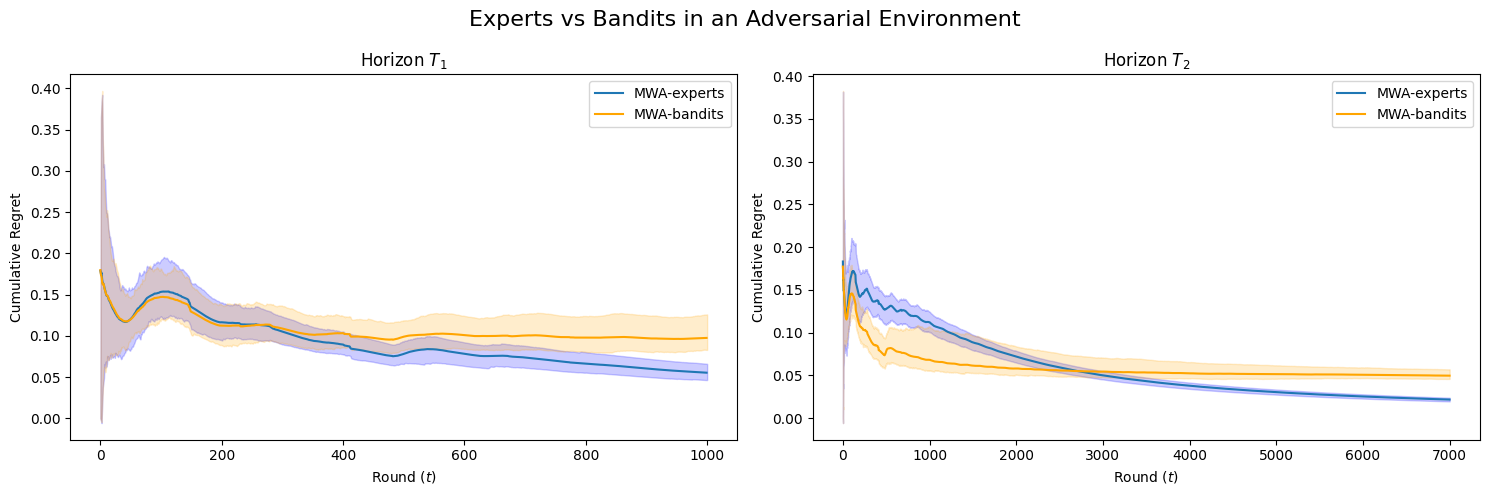

In [31]:
# Create a figure with two subplots (horizontally stacked)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the expected regret over time steps for the experts setting - Horizon T1
ax1.plot(expected_experts_regret_T1[1::], label='MWA-experts')

# Fill the area between the minimum and maximum regret observed at each time step for the experts setting - Horizon T1
ax1.fill_between(np.arange(len(expected_experts_regret_T1)), np.min(experts_regret_T1, axis=0), np.max(experts_regret_T1, axis=0), color='blue', alpha=0.2)

# Plot the expected regret over time steps for the bandits setting - Horizon T1
ax1.plot(expected_bandits_regret_T1[1::], color='orange',  label='MWA-bandits')

# Fill the area between the minimum and maximum regret observed at each time step for the bandits setting - Horizon T1
ax1.fill_between(np.arange(len(expected_bandits_regret_T1)), np.min(bandits_regret_T1, axis=0), np.max(bandits_regret_T1, axis=0), color='orange', alpha=0.2)

# Add title and axis labels for the first subplot (Horizon T1)
ax1.set_title('Horizon $T_1$')
ax1.set_xlabel('Round ($t$)')
ax1.set_ylabel('Cumulative Regret')

# Show the legend for the first subplot
ax1.legend()

# Plot the expected regret over time steps for the experts setting - Horizon T2
ax2.plot(expected_experts_regret_T2[1::], label='MWA-experts')

# Fill the area between the minimum and maximum regret observed at each time step for the experts setting - Horizon T2
ax2.fill_between(np.arange(len(expected_experts_regret_T2)), np.min(experts_regret_T2, axis=0), np.max(experts_regret_T2, axis=0), color='blue', alpha=0.2)

# Plot the expected regret over time steps for the bandits setting - Horizon T2
ax2.plot(expected_bandits_regret_T2[1::], color='orange',  label='MWA-bandits')

# Fill the area between the minimum and maximum regret observed at each time step for the bandits setting - Horizon T2
ax2.fill_between(np.arange(len(expected_bandits_regret_T2)), np.min(bandits_regret_T2, axis=0), np.max(bandits_regret_T2, axis=0), color='orange', alpha=0.2)

# Add title and axis labels for the second subplot (Horizon T2)
ax2.set_title('Horizon $T_2$')
ax2.set_xlabel('Round ($t$)')
ax2.set_ylabel('Cumulative Regret')

# Show the legend for the second subplot
ax2.legend()

# Set the main title for the whole figure
fig.suptitle('Experts vs Bandits in an Adversarial Environment', fontsize=16)

# Adjust the spacing between the subplots for better visualization
plt.tight_layout()

# Show the plot with both subplots
plt.show()

Note that analyzing two different horizons is beneficial since the non-stationary environment can cause the server that is the least loaded for the first 1000 time steps, to no longer be optimal after 7000 steps. Nevertheless, the plots validate the theory no matter the horizon. The "Experts" setting of the MWA outperforms the "Bandits" setting as it converges to zero regret at a faster rate. But, as we said, this is to be expected as in the "Bandit" setup, we require a minimum of $k$ rounds to obtain the same amount of information for $k$ servers as we would obtain in the "Experts" setup.